# Analysis by using a second video

In [80]:
import cv2
from cv2 import aruco
import numpy as np
import msgpack as mp
import msgpack_numpy as mpn
import os
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from joblib import Parallel, delayed

In [81]:
_pth = os.path.dirname(os.getcwd())
_parent_folder = "data"
_calib_folder_name = "calib_mono_160fov_raw"
_recording_folder_name = "randomxyz_t0"

_webcam_calib_folder = os.path.join(
    _pth,'..', _parent_folder, "calibration",'160_fov', _calib_folder_name
)

_reference_recording_folder = os.path.join(
    _pth, '..', _parent_folder, "recordings",'160_fov','3marker_complete_data', _recording_folder_name
)
_reference_file = os.path.join(_reference_recording_folder, "webcam_color.msgpack")

# for loading 9000 values
_calibration_data = os.path.join(_webcam_calib_folder, 'calibration_data_9000.msgpack')

# for loading just 100 points
_calibration_data = os.path.join(_webcam_calib_folder, 'calibration_data.msgpack')

_timestamp_file = os.path.join(_reference_recording_folder, "webcam_timestamp.msgpack")
with open(_timestamp_file, "rb") as f:
    _metadata = list(mp.Unpacker(f, object_hook=mpn.decode))
    _timestamp = np.array(_metadata)[:,1]
    _sync_pulse = np.array(_metadata)[:,0]
    


In [82]:
_ref_video_length = 0

for _ in mp.Unpacker(open(_reference_file, "rb"), object_hook=mpn.decode):
    _ref_video_length += 1

print('video length, ', _ref_video_length)

video length,  2861


In [83]:
ARUCO_PARAMETERS = aruco.DetectorParameters()
ARUCO_DICT = aruco.getPredefinedDictionary(aruco.DICT_APRILTAG_36h11)
detector = aruco.ArucoDetector(ARUCO_DICT, ARUCO_PARAMETERS)
markerLength = 0.05
markerSeperation = 0.01

board = aruco.GridBoard(
    size=[1, 1],
    markerLength=markerLength,
    markerSeparation=markerSeperation,
    dictionary=ARUCO_DICT,
)

def estimate_pose_single_markers(
    corners, marker_size, camera_matrix, distortion_coefficients = np.zeros((5, 1))
):
    marker_points = np.array(
        [
            [-marker_size / 2, marker_size / 2, 0],
            [marker_size / 2, marker_size / 2, 0],
            [marker_size / 2, -marker_size / 2, 0],
            [-marker_size / 2, -marker_size / 2, 0],
        ],
        dtype=np.float32,
    )
    rvecs, tvecs = [], []
    for corner in corners:
        _, r, t = cv2.solvePnP(
            marker_points,
            corner,
            camera_matrix,
            distortion_coefficients,
            flags=cv2.SOLVEPNP_ITERATIVE,
        )
        if r is not None and t is not None:
            rvecs.append(r.reshape(1, 3).tolist())
            tvecs.append(t.reshape(1, 3).tolist())
        else:
            rvecs.append(np.array([[np.nan, np.nan, np.nan]]).tolist())
            tvecs.append(np.array([[np.nan, np.nan, np.nan]]).tolist())
    return np.array(rvecs, dtype=np.float32), np.array(tvecs, dtype=np.float32)

## load clalibration data

In [84]:
_calib_data = list(mp.Unpacker(open(_calibration_data, "rb"), object_hook=mpn.decode))

In [ ]:
# _calib_data

In [86]:
_calib_data[0]

0

In [85]:
len(_calib_data[0]['ReError'])

TypeError: 'int' object is not subscriptable

In [ ]:
# selecting random 50 frames
np.random.seed(9)
_random_reference_frames_idx = np.random.choice(_ref_video_length, 300)

_ref_data = mp.Unpacker(open(_reference_file, "rb"), object_hook=mpn.decode)

# _ref_frames = []

ar_total_results = {'calib_idx':[], 'ar_data':[]}
ar_results = {'corners': [], 'ids': [], 'rejected': []}
vector_std = {'v1std':[], 'v2std':[], 'v3std':[], 'sum':[], 
              'r1std':[], 'r2std':[], 'r3std':[], 'r_sum':[]}

for idx, _frame in tqdm(enumerate(_ref_data)):
    # if idx in _random_reference_frames_idx:

        # _frame = cv2.rotate(_frame, cv2.ROTATE_180)
    _frame = cv2.flip(_frame, 1)
    res = detector.detectMarkers(_frame,)
    
    res = detector.refineDetectedMarkers(_frame, board, res[0], res[1], res[2])
    ar_results['corners'].append(res[0])
    ar_results['ids'].append(res[1])
    ar_results['rejected'].append(res[2])

0it [00:00, ?it/s]

In [ ]:

# Alternative approach using a more flexible data structure
def process_aruco_detections(ar_results, target_ids=[12, 14, 20]):
    """
    Process ArUco detection results, handling missing IDs gracefully.
    
    Args:
        ar_results: Dictionary containing 'ids', 'corners', 'rvecs', 'tvecs'
        target_ids: List of marker IDs we want to track
    
    Returns:
        Dictionary with transformed translation vectors for each target ID
    """
    transformed_tvec = {str(tid): [] for tid in target_ids}
    initial_rmat = None
    initial_tvec = None
    
    for frame_idx in range(len(ar_results['ids'])):
        if ar_results['ids'][frame_idx] is None or len(ar_results['ids'][frame_idx]) == 0:
            # No markers detected in this frame
            for target_id in target_ids:
                transformed_tvec[str(target_id)].append(np.full(3, np.nan))
            continue
            
        # Sort detections by ID for consistency
        sorted_indices = np.argsort(ar_results['ids'][frame_idx])
        sorted_ids = ar_results['ids'][frame_idx][sorted_indices]
        sorted_rvecs = ar_results['rvecs'][frame_idx][sorted_indices]
        sorted_tvecs = ar_results['tvecs'][frame_idx][sorted_indices]
        
        # Initialize reference frame from first detection
        if initial_rmat is None:
            initial_rmat = cv2.Rodrigues(sorted_rvecs[0])[0]
            initial_tvec = sorted_tvecs[0]
            # For the first frame, just fill with NaN (or zeros if preferred)
            for target_id in target_ids:
                transformed_tvec[str(target_id)].append(np.full(3, np.nan))
            continue
        
        # Transform all detected markers to reference frame
        temp_vec = sorted_tvecs.reshape(-1, 3).T - initial_tvec.reshape(-1, 3).T
        transformed_positions = (initial_rmat.T @ temp_vec).T
        
        # Create mapping from ID to transformed position
        id_to_position = dict(zip(sorted_ids, transformed_positions))
        
        # Append results for each target ID
        for target_id in target_ids:
            if target_id in id_to_position:
                transformed_tvec[str(target_id)].append(id_to_position[target_id])
            else:
                transformed_tvec[str(target_id)].append(np.full(3, np.nan))
    
    return transformed_tvec

# Usage example:
# transformed_tvec = process_aruco_detections(ar_results, target_ids=[12, 14, 20])

# For handling NaN values later in your analysis:
def clean_transformed_data(transformed_tvec):
    """Remove NaN entries and return valid data points with their indices."""
    cleaned_data = {}
    for marker_id, positions in transformed_tvec.items():
        positions_array = np.array(positions)
        # Find rows where all values are not NaN
        valid_mask = ~np.isnan(positions_array).all(axis=1)
        cleaned_data[marker_id] = {
            'positions': positions_array[valid_mask],
            'frame_indices': np.where(valid_mask)[0]
        }
    return cleaned_data

def undistort_aruco_corners_fisheye(corners, camera_matrix, dist_coeffs):
    """
    Undistort ArUco corners using fisheye camera model.
    
    Args:
        corners: List of corner arrays from ArUco detection
        camera_matrix: Original fisheye camera matrix
        dist_coeffs: Fisheye distortion coefficients
    
    Returns:
        undistorted_corners: List of undistorted corner arrays
    """
    if corners is None or len(corners) == 0:
        return corners
    
    undistorted_corners = []
    
    for corner_set in corners:
        # Reshape corners to the format expected by undistortPoints
        corner_points = corner_set.reshape(-1, 1, 2).astype(np.float32)
        
        # Undistort using fisheye model
        undistorted_points = cv2.fisheye.undistortPoints(
            corner_points,
            camera_matrix,
            dist_coeffs,
            P=camera_matrix
        )
        
        # Reshape back to original format
        undistorted_corner_set = undistorted_points.reshape(corner_set.shape)
        undistorted_corners.append(undistorted_corner_set)
    
    return undistorted_corners

In [ ]:
import numpy as np
from scipy import stats
from tqdm import tqdm
import cv2
from joblib import Parallel, delayed

# Define filtering functions outside the loop
def filter_90th_percentile_zscore(data, z_threshold=1.28):  # z=1.28 corresponds to ~90th percentile
    """Filter data to keep only values within 90th percentile using z-score"""
    data = np.array(data)
    data_clean = data[~np.isnan(data)]  # Remove NaN values
    if len(data_clean) == 0:
        return data_clean
    
    z_scores = np.abs(stats.zscore(data_clean))
    return data_clean[z_scores <= z_threshold]

def filter_90th_percentile_direct(data):
    """Filter data to keep only values up to 90th percentile"""
    data = np.array(data)
    data_clean = data[~np.isnan(data)]  # Remove NaN values
    if len(data_clean) == 0:
        return data_clean
    
    percentile_90 = np.percentile(data_clean, 90)
    return data_clean[data_clean <= percentile_90]

def process_single_calibration_optimized(idx, mat, dist, preprocessed_corners, preprocessed_ids):
    """Optimized version - processes only pose estimation per calibration"""
    _ar_results = {'corners': [], 'ids': [], 'rvecs': [], 'tvecs': []}
    
    for corners, ids in zip(preprocessed_corners, preprocessed_ids):
        # Undistort corners for this specific calibration
        if corners is not None and len(corners) > 0:
            undistorted_corners = undistort_aruco_corners_fisheye(corners, mat, dist)
            _ar_results['corners'].append(undistorted_corners)
            _ar_results['ids'].append(ids)
            
            # Estimate pose
            rvecs, tvecs = estimate_pose_single_markers(
                undistorted_corners, markerLength, mat, dist
            )
            _ar_results['rvecs'].append(rvecs)
            _ar_results['tvecs'].append(tvecs)
        else:
            _ar_results['corners'].append([])
            _ar_results['ids'].append([])
            _ar_results['rvecs'].append([])
            _ar_results['tvecs'].append([])

    # Process ArUco detections once per calibration
    transformed_tvec = process_aruco_detections(_ar_results, target_ids=[12, 14, 20])
    transformed_tvec = clean_transformed_data(transformed_tvec)
    
    return {
        'calib_idx': idx,
        'ar_data': transformed_tvec,
    }

# Pre-process ArUco detection data (extract corners and IDs)
print("Pre-processing ArUco detection data...")
preprocessed_corners = []
preprocessed_ids = []

for corners, ids in zip(ar_results['corners'], ar_results['ids']):
    preprocessed_corners.append(corners)
    if ids is not None:
        preprocessed_ids.append(np.array(ids).T.reshape(-1))
    else:
        preprocessed_ids.append([])

print(f"Preprocessed {len(preprocessed_corners)} frames")

# Parallel processing of calibration matrices with optimizations
print("Processing calibration matrices in parallel...")
calibration_data = list(zip(_calib_data[0]['mat'], _calib_data[0]['dist']))

# Reduce worker count for better memory management
# Use batch processing to reduce memory overhead
batch_size = 100
n_workers = min(8, len(calibration_data) // 10)  # Adaptive worker count

print(f"Using {n_workers} workers with batch size {batch_size}")

# Process in batches to manage memory better
for batch_start in range(0, len(calibration_data), batch_size):
    batch_end = min(batch_start + batch_size, len(calibration_data))
    batch_data = calibration_data[batch_start:batch_end]
    
    print(f"Processing batch {batch_start//batch_size + 1}/{(len(calibration_data)-1)//batch_size + 1}")
    
    # Process batch in parallel
    batch_results = Parallel(n_jobs=n_workers, verbose=1)(
        delayed(process_single_calibration_optimized)(
            batch_start + idx, 
            cal[0], 
            cal[1], 
            preprocessed_corners, 
            preprocessed_ids
        ) 
        for idx, cal in enumerate(batch_data)
    )
    
    # Collect results
    for result in batch_results:
        ar_total_results['calib_idx'].append(result['calib_idx'])
        ar_total_results['ar_data'].append(result['ar_data'])

print(f"Completed processing {len(ar_total_results['calib_idx'])} calibrations")

Pre-processing ArUco detection data...
Preprocessed 2861 frames
Processing calibration matrices in parallel...
Using 8 workers with batch size 100
Processing batch 1/20


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   17.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   43.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Processing batch 2/20


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   15.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   40.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Processing batch 3/20


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   15.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   40.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Processing batch 4/20


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   15.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   41.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Processing batch 5/20


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   16.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   41.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Processing batch 6/20


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   15.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   40.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Processing batch 7/20


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   15.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   39.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Processing batch 8/20


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   15.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   39.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Processing batch 9/20


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   15.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   39.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Processing batch 10/20


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   15.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   39.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Processing batch 11/20


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   15.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   39.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Processing batch 12/20


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   15.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   39.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Processing batch 13/20


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   15.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   40.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Processing batch 14/20


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   15.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   39.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Processing batch 15/20


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   15.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   39.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Processing batch 16/20


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   15.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   39.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Processing batch 17/20


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   15.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   39.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Processing batch 18/20


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   15.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   40.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Processing batch 19/20


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   15.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   39.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Processing batch 20/20


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   15.6s


Completed processing 2000 calibrations


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   40.7s finished


In [ ]:
_optimization_file = os.path.join(_webcam_calib_folder, "optimization_file_9000_mocap.msgpack")

with open(_optimization_file, "wb") as f:
    _packed_file = mp.packb([ar_total_results, vector_std], default=mpn.encode)
    f.write(_packed_file)

In [ ]:
_sync_pulse = np.array(_sync_pulse).astype(np.int8)
_start_pulse = 0
_end_pulse = 0
for idx, _s in enumerate(_sync_pulse):
    if _s:
        _start_pulse = idx
        break
for idx, _s in enumerate(_sync_pulse[_start_pulse:]):
    if _s == 0:
        _end_pulse = idx
        break

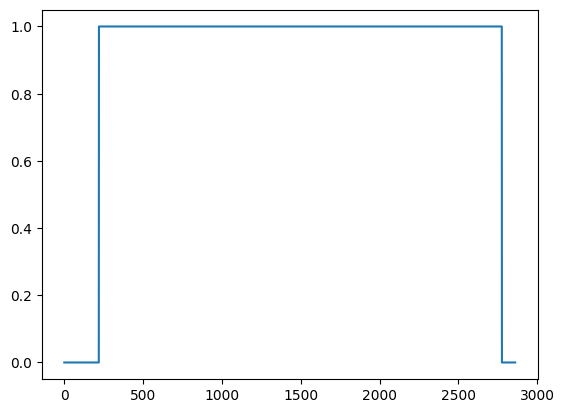

In [ ]:
plt.plot(_sync_pulse)

In [ ]:

import sys
sys.path.insert(1, os.path.dirname(os.getcwd()))
from pd_support import *


_movement_data_path = _reference_recording_folder
_folder_name = _recording_folder_name
_mocap_pth = os.path.join(os.path.dirname(_movement_data_path), _folder_name,f"{_folder_name}.csv")

mocap_df, st_time = read_rigid_body_csv(_mocap_pth)
mocap_df = add_datetime_col(mocap_df, st_time, 'seconds')


e:\CMC\pyprojects\programs_rpi\rpi_python\notebooks\pd_support.py:326: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  _rb_df = _rb_df.apply(pd.to_numeric, errors="ignore")


In [ ]:
_time_offset = datetime.strptime(str(_timestamp[_start_pulse]), "%Y-%m-%d %H:%M:%S.%f") - mocap_df['time'][0]

rb_quat = mocap_df[['rb_ang_x', 'rb_ang_y', 'rb_ang_z', 'rb_ang_w']].values
rb_pos = mocap_df[['rb_pos_x', 'rb_pos_y', 'rb_pos_z']].values
from scipy.spatial.transform import Rotation as R
rb_matrix = R.from_quat(rb_quat[0]).as_matrix()
transformed_rb_pos = (rb_matrix.T @ (rb_pos.T - rb_pos[0].reshape(3,1))).T
rotation_correction = R.from_euler('xyz', [90, 0, 0], degrees=True).as_matrix()
transformed_rb_pos = (rotation_correction.T @ transformed_rb_pos.T).T

In [ ]:
import pandas as pd
from scipy.interpolate import interp1d
error_dict = {'max_x':[], 'max_y':[], 'max_z':[], 'mean_x':[], 'mean_y':[], 'mean_z':[],
              'std_x':[], 'std_y':[], 'std_z':[], 'total_error':[]}

for _i in range(len(ar_total_results['ar_data'])):
    data = ar_total_results['ar_data'][_i]
    df = pd.DataFrame(data['12']['positions'], columns=['x', 'y', 'z'])
    df['time'] = pd.to_datetime(_timestamp[1:])

    df = df[_start_pulse:_end_pulse].reset_index(drop=True)
    df['time'] = df['time'] - _time_offset
    
    _cols = ['x', 'y', 'z']
    _ar_df = pd.DataFrame()
    _ar_df['time'] = mocap_df['time']
    for col in _cols:
        _interp_func = interp1d(
            df['time'].astype(np.int64), 
            df[col], 
            bounds_error=False, 
            fill_value='extrapolate'
        )
        _ar_df[col] = _interp_func(mocap_df['time'].astype(np.int64))

    _ar_values = _ar_df[_cols].values
    
    _ar_t = _ar_values.T
    _ar_t[0] = -1*_ar_t[0]
    _ar_t[2] = -1*_ar_t[2]
    _ar_values = _ar_t.T
    diff = _ar_values[:2000] - transformed_rb_pos[:2000]

    error_dict['max_x'].append(np.nanmax(np.abs(diff[:,0])))
    error_dict['max_y'].append(np.nanmax(np.abs(diff[:,1])))
    error_dict['max_z'].append(np.nanmax(np.abs(diff[:,2])))
    error_dict['mean_x'].append(np.nanmean(diff[:,0]))
    error_dict['mean_y'].append(np.nanmean(diff[:,1]))
    error_dict['mean_z'].append(np.nanmean(diff[:,2]))
    error_dict['std_x'].append(np.nanstd(diff[:,0]))
    error_dict['std_y'].append(np.nanstd(diff[:,1]))
    error_dict['std_z'].append(np.nanstd(diff[:,2]))
    error_dict['total_error'].append(np.nansum(np.abs(diff)))


In [ ]:
data = ar_total_results['ar_data'][781]
df = pd.DataFrame(data['12']['positions'], columns=['x', 'y', 'z'])
df['time'] = pd.to_datetime(_timestamp[1:])

df = df[_start_pulse:_end_pulse].reset_index(drop=True)
df['time'] = df['time'] - _time_offset

_cols = ['x', 'y', 'z']
_ar_df = pd.DataFrame()
_ar_df['time'] = mocap_df['time']
for col in _cols:
    _interp_func = interp1d(
        df['time'].astype(np.int64), 
        df[col], 
        bounds_error=False, 
        fill_value='extrapolate'
    )
    _ar_df[col] = _interp_func(mocap_df['time'].astype(np.int64))

_ar_values = _ar_df[_cols].values

_ar_t = _ar_values.T
_ar_t[0] = -1*_ar_t[0]
_ar_t[2] = -1*_ar_t[2]
_ar_values = _ar_t.T
diff = _ar_values[:2000] - transformed_rb_pos[:2000]

In [ ]:
np.argmin(error_dict['max_y'])

np.int64(781)

In [ ]:
print(np.argmin(np.abs(np.array(error_dict['max_x'])) + np.abs(np.array(error_dict['max_y'])) + np.abs(np.array(error_dict['max_z']))))
print(np.min(np.abs(np.array(error_dict['max_x'])) + np.abs(np.array(error_dict['max_y'])) + np.abs(np.array(error_dict['max_z']))))

1810
0.08271515902960297


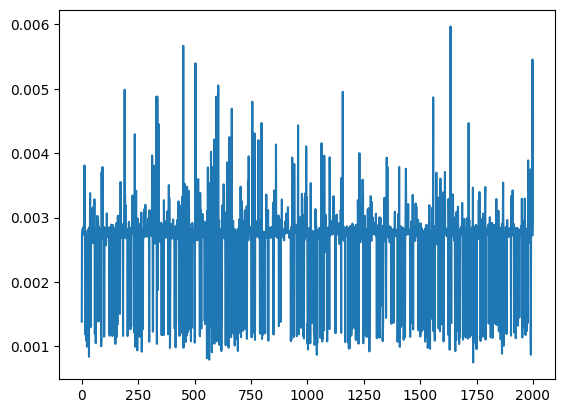

In [ ]:
plt.plot(np.abs(np.array(error_dict['mean_x'])))

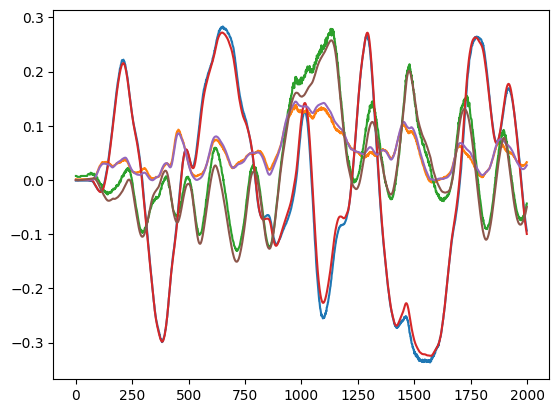

In [ ]:
plt.plot(_ar_values[:2000])
plt.plot(transformed_rb_pos[:2000])

In [ ]:
np.nanmean()

np.float64(0.16458943596243023)

In [ ]:
np.abs(diff[:,0])

array([0.00110723, 0.00109859, 0.00111718, ..., 0.31629674, 0.32057712,
       0.32832167], shape=(2000,))

In [ ]:
len(np.array(error_dict['mean_x']) + np.array(error_dict['mean_y']) + np.array(error_dict['mean_z']))

2000

In [ ]:
np.argmin(error_dict['max_y'])

np.int64(1328)

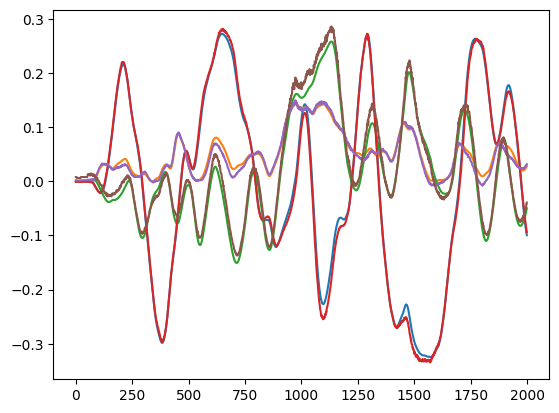

In [ ]:
data = ar_total_results['ar_data'][10]
df = pd.DataFrame(data['12']['positions'], columns=['x', 'y', 'z'])
df['time'] = pd.to_datetime(_timestamp[1:])

df = df[_start_pulse:_end_pulse].reset_index(drop=True)
df['time'] = df['time'] - _time_offset

_cols = ['x', 'y', 'z']
_ar_df = pd.DataFrame()
_ar_df['time'] = mocap_df['time']
for col in _cols:
    _interp_func = interp1d(
        df['time'].astype(np.int64), 
        df[col], 
        bounds_error=False, 
        fill_value='extrapolate'
    )
    _ar_df[col] = _interp_func(mocap_df['time'].astype(np.int64))

_ar_values = _ar_df[_cols].values

_ar_t = _ar_values.T
_ar_t[0] = -1*_ar_t[0]
_ar_t[2] = -1*_ar_t[2]
_ar_values = _ar_t.T

plt.plot(transformed_rb_pos[:2000])
plt.plot(_ar_values[:2000])

In [ ]:
transformed_rb_pos[:2000] - _ar_values[:2000]

array([[ 0.00110609, -0.00192831, -0.00780307],
       [ 0.00109744, -0.00194828, -0.00782774],
       [ 0.00111603, -0.00195438, -0.00787034],
       ...,
       [-0.00527467, -0.00468259, -0.01192243],
       [-0.00535765, -0.00363572, -0.00987889],
       [-0.00578124, -0.00415042, -0.01051102]])

In [ ]:
np.argmin(np.array(error_dict['mean_x']) + np.array(error_dict['mean_y']) + np.array(error_dict['mean_z']))

np.int64(1328)